# Quantum Principal Component Analysis (QPCA)
## Step 1: Input Quantum State |ψA0⟩

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Function to create a symmetric correlation matrix
def create_correlation_matrix(dimension):
    random_matrix = np.random.rand(dimension, dimension)
    correlation_matrix = (random_matrix + random_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    eigenvalues, _ = np.linalg.eigh(correlation_matrix)
    if np.any(eigenvalues < 0):
        min_eig = np.min(eigenvalues)
        correlation_matrix += np.eye(dimension) * (abs(min_eig) + 0.01)
        d = np.sqrt(np.diag(correlation_matrix))
        correlation_matrix = correlation_matrix / np.outer(d, d)
    
    return correlation_matrix


## Step 2: Phase Estimation UP_E

In [11]:
# Inverse Quantum Fourier Transform
def inverse_qft(circuit, qubits):
    n = len(qubits)
    for qubit in range(n-1, -1, -1):
        for control in range(qubit):
            angle = -2 * np.pi / (2 ** (qubit - control + 1))
            circuit.cp(angle, qubits[control], qubits[qubit])
        circuit.h(qubits[qubit])
    return circuit


## Step 3: Unitary Operation Uσ,τ

In [12]:
# Function to visualize quantum states and measurements
def visualize_quantum_states(correlation_matrix, threshold, precision_qubits):
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
    normalized_eigenvalues = (eigenvalues - np.min(eigenvalues)) / (np.max(eigenvalues) - np.min(eigenvalues))
    
    thresholded_indices = np.where(normalized_eigenvalues >= threshold)[0]
    thresholded_eigenvalues = normalized_eigenvalues[thresholded_indices]
    
    n_qubits = len(correlation_matrix)
    total_qubits = 8
    
    circuit = QuantumCircuit(total_qubits, precision_qubits)

    for i in range(precision_qubits):
        circuit.h(i)

    control_qubits = list(range(precision_qubits))
    target_qubits = list(range(precision_qubits, precision_qubits + n_qubits))

    for i in range(precision_qubits):
        for j in range(n_qubits):
            phase = normalized_eigenvalues[j] * (2**i) * 2 * np.pi
            if precision_qubits + j < total_qubits:
                circuit.cp(phase, i, precision_qubits + j)

    inverse_qft(circuit, range(precision_qubits))
    circuit.measure(range(precision_qubits), range(precision_qubits))

    simulator = AerSimulator()
    transpiled_circuit = transpile(circuit, simulator)
    job = simulator.run(transpiled_circuit, shots=1000)
    result = job.result()
    measurement_results = result.get_counts()

    print(circuit)
    
    return {
        'correlation_matrix': correlation_matrix,
        'eigenvalues': eigenvalues,
        'normalized_eigenvalues': normalized_eigenvalues,
        'thresholded_eigenvalues': thresholded_eigenvalues,
        'eigenvectors': eigenvectors,
        'circuit': circuit,
        'measurement_results': measurement_results
    }


## Step 4: Applying Controlled Rotation Ry(α)

In [13]:
# Run the QPCA process
dimension = 2
correlation_matrix = create_correlation_matrix(dimension)
threshold = 0.5
precision_qubits = 2

results = visualize_quantum_states(correlation_matrix, threshold, precision_qubits)


     ┌───┐                                        ┌───┐┌─┐   
q_0: ┤ H ├─■──────■──────────────────────■────────┤ H ├┤M├───
     ├───┤ │      │                      │P(-π/2) ├───┤└╥┘┌─┐
q_1: ┤ H ├─┼──────┼───────■──────■───────■────────┤ H ├─╫─┤M├
     └───┘ │P(0)  │       │P(0)  │                └───┘ ║ └╥┘
q_2: ──────■──────┼───────■──────┼──────────────────────╫──╫─
                  │P(2π)         │P(4π)                 ║  ║ 
q_3: ─────────────■──────────────■──────────────────────╫──╫─
                                                        ║  ║ 
q_4: ───────────────────────────────────────────────────╫──╫─
                                                        ║  ║ 
q_5: ───────────────────────────────────────────────────╫──╫─
                                                        ║  ║ 
q_6: ───────────────────────────────────────────────────╫──╫─
                                                        ║  ║ 
q_7: ───────────────────────────────────────────────────╫──╫─
        

## Step 5: Measurement and Visualization


Correlation Matrix:
 [[1.         0.56067998]
 [0.56067998 1.        ]]

Eigenvalues:
 [0.43932002 1.56067998]

Normalized Eigenvalues:
 [0. 1.]

Thresholded Eigenvalues:
 [1.]


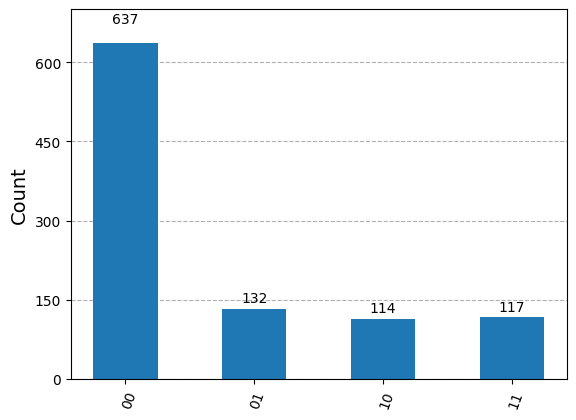

In [14]:
# Display results
print("\nCorrelation Matrix:\n", results['correlation_matrix'])
print("\nEigenvalues:\n", results['eigenvalues'])
print("\nNormalized Eigenvalues:\n", results['normalized_eigenvalues'])
print("\nThresholded Eigenvalues:\n", results['thresholded_eigenvalues'])
plot_histogram(results['measurement_results'])
